In [1]:
import sys
import os

current_directory = os.getcwd()        
parent_directory = os.path.dirname(current_directory)
sys.path.append(parent_directory)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from tensorflow import keras
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from spektral.layers import GCNConv

from postprocess.threshold import flood_threshold, drought_threshold
from preprocess.BaselinePrerocess import baseline_process, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology_5

import pygad
import time

2023-08-05 00:04:08.770481: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-05 00:04:10.309919: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5"

### Preprocess

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [6]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


### Select event

In [7]:
start_idx = 1050
end_idx = 1120
duration = end_idx - start_idx

In [8]:
ws1 = test_ws_y[start_idx:end_idx, :]
ws1 = ws_scaler.inverse_transform(ws1)
ws1.shape

(70, 96)

In [9]:
# plt.plot(ws1[:, 0], label='S1')
# plt.xlabel('Time', fontsize=18)
# plt.ylabel('S1 Water Stage', fontsize=18)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.legend(fontsize=14)
# plt.show()

### Get optimizable and not optimizable variables

In [10]:
# X = test_X_mask[start_idx:end_idx, :, :]
# X_1d = np.reshape(X, -1)

# print(X.shape)
# print(X_1d.shape)

In [11]:
# optimizable
gate_state = test_cov[start_idx:end_idx, :, 2:9]
gate_state_1d = np.reshape(gate_state, -1)

print(gate_state.shape)
print(gate_state_1d.shape)

(70, 96, 7)
(47040,)


In [12]:
# not optimizable
not_gate1 = test_cov[start_idx:end_idx, :, 0:2]

print(not_gate1.shape)

(70, 96, 2)


In [13]:
# not optimizable
not_gate2 = test_cov[start_idx:end_idx, :, 9:]

print(not_gate2.shape)

(70, 96, 3)


### GA

In [14]:
saved_model = load_model('../saved_models/WaLeF_gtn_p.h5', custom_objects={'GCNConv': GCNConv})

2023-08-05 00:04:19.651961: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:85:00.0, compute capability: 6.1


In [15]:
def fitness_func(ga_instance, solution, solution_idx):
    # ================ gate penalty ================
    solution = np.reshape(solution, (duration, 96*7))
    gate_max = 1
    gate_min = 0
    
    gate_penalty_sum = 0
    for i in range(duration):
        for j in range(96*7):
            if (solution[i, j] > gate_max):
                penalty_gate = np.abs(solution[i, j] - gate_max)**2
            elif (solution[i, j] < gate_min):
                penalty_gate = np.abs(solution[i, j] - gate_min)**2
            else:
                penalty_gate = 0
            gate_penalty_sum += penalty_gate

    # ================ get input numpy of gate ================
    solution = np.reshape(solution, (duration, 96, 7))
    input_np = np.zeros(((duration, 96, 12)))
    input_np[:, :, 0:2] = not_gate1
    input_np[:, :, 2:9] = solution
    input_np[:, :, 9:] = not_gate2
    
    # ================ predict ws ================
    yhat = saved_model.predict([input_np, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
    #yhat = saved_model.predict(input_np, verbose=0)
    
    
    # ================ ws penalty ================
    y_max = 0.62
    y_min = 0.2
    
    ws_penalty_sum = 0
    for i in range (duration):
        for j in range (96):
            if (yhat[i, j] > y_max):
                penalty_ws = np.abs(yhat[i, j] - y_max) + 20*np.abs(yhat[i, j] - y_max)**2
            elif (yhat[i, j] < y_min):
                penalty_ws = np.abs(y_min - yhat[i, j])
                
            else:
                penalty_ws = 0
            
            ws_penalty_sum += penalty_ws
    
    # ================ gate penalty + ws penalty ================
    penalty_gate_ws_sum = 0.2*gate_penalty_sum + 2.0*ws_penalty_sum
    
    if penalty_gate_ws_sum == 0:
        fitness = 9999999999999
    else:
        fitness = 1.0 / penalty_gate_ws_sum
    return fitness

In [16]:
fitness_function = fitness_func

num_generations = 200
num_parents_mating = 16

sol_per_pop = 96
num_genes = len(gate_state_1d)

init_range_low = 0
init_range_high = 1

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 5

In [17]:
ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes,
                       gene_space = {'low': 0, 'high': 1})

In [18]:
start_time = time.perf_counter()
ga_instance.run()
cpu_time = time.perf_counter() - start_time
print(f"CPU time: {cpu_time} seconds")

2023-08-05 00:04:22.596768: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 6ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 5ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 5ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 5ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step


3/3 [==============================] - 0s 4ms/step
CPU time: 3170.5166186229326 seconds


In [19]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

3/3 [==============================] - 0s 4ms/step
Parameters of the best solution : [0.29808439 0.49857598 0.97585103 ... 0.72727324 0.24114454 0.54950833]
Fitness value of the best solution = 0.00846919458993918


### Post-processing

In [20]:
best_gate = np.reshape(solution, (duration, 96, 7))

best_input = np.zeros(((duration, 96, 12)))
best_input[:, :, 0:2] = not_gate1
best_input[:, :, 2:9] = best_gate
best_input[:, :, 9:] = not_gate2

best_perf = saved_model.predict([best_input, test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
best_perf = ws_scaler.inverse_transform(best_perf)

3/3 [==============================] - 0s 4ms/step


In [21]:
count = 0

for i in range (duration):
    for j in range (96):
        if best_perf[i, j] > 3.5:
            count += 1

print(count)

0


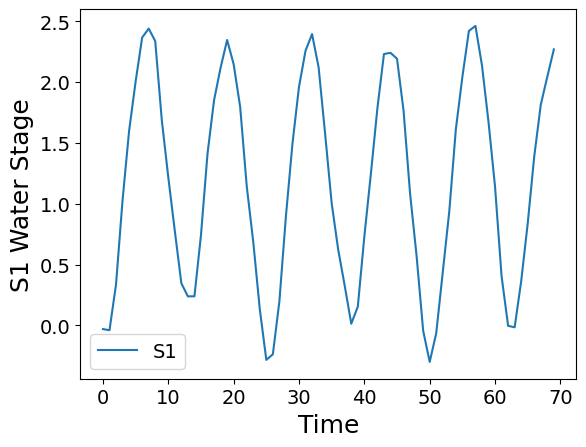

In [22]:
plt.plot(best_perf[:, 0], label='S1')
plt.xlabel('Time', fontsize=18)
plt.ylabel('S1 Water Stage', fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [23]:
Optimal_gate = pd.DataFrame(best_gate.reshape(duration, -1) )
Optimal_gate.to_csv("GA_results/best_gate_event_low2.csv", index=False)
Optimal_gate

,0,1,2,3,4,5,6,7,8,9,...,662,663,664,665,666,667,668,669,670,671
0,0.298084,0.498576,0.975851,0.704994,0.627695,0.599722,0.513762,0.409468,0.094887,0.052183,...,0.929689,0.476548,0.872569,0.271732,0.046132,0.388542,0.436718,0.001929,0.081019,0.645767
1,0.549398,0.152094,0.921325,0.950267,0.022958,0.833836,0.581256,0.065489,0.593494,0.905762,...,0.755762,0.343114,0.264305,0.921620,0.981571,0.992494,0.196798,0.140515,0.223136,0.617259
2,0.018719,0.737814,0.739690,0.466360,0.383379,0.512234,0.389643,0.341148,0.864911,0.880585,...,0.560962,0.919966,0.067567,0.936594,0.548136,0.577789,0.343768,0.892321,0.177236,0.973982
3,0.424293,0.882656,0.607787,0.496671,0.205172,0.721115,0.560308,0.989396,0.163213,0.339465,...,0.853293,0.570852,0.402376,0.886440,0.119986,0.060425,0.390392,0.647039,0.936914,0.422040
4,0.344768,0.736467,0.597740,0.052822,0.730483,0.628066,0.730080,0.653218,0.823331,0.206435,...,0.684800,0.655283,0.717480,0.970191,0.510243,0.666835,0.421853,0.251036,0.834679,0.886563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0.655477,0.910961,0.464324,0.297048,0.709868,0.638457,0.501390,0.613087,0.271577,0.286432,...,0.892415,0.531145,0.685856,0.579333,0.220816,0.408735,0.279168,0.862866,0.180822,0.961974
66,0.457086,0.041681,0.960933,0.807298,0.650249,0.160330,0.494964,0.693813,0.094183,0.674760,...,0.558793,0.316052,0.024981,0.843075,0.447699,0.403656,0.943873,0.999462,0.397847,0.205541
67,0.640192,0.601231,0.532706,0.467756,0.214810,0.748180,0.626348,0.695415,0.443804,0.104768,...,0.132683,0.644616,0.021343,0.096833,0.635851,0.711046,0.311933,0.795074,0.349211,0.897966
68,0.959213,0.869920,0.146683,0.950182,0.400228,0.079382,0.051526,0.881697,0.549587,0.278893,...,0.439345,0.217261,0.486721,0.968912,0.483470,0.200053,0.196968,0.419973,0.342378,0.300687


In [24]:
Optimal_case = pd.DataFrame(best_perf)
Optimal_case.to_csv("GA_results/best_performance_event_low2.csv", index=False)
Optimal_case

,0,1,2,3,4,5,6,7,8,9,...,86,87,88,89,90,91,92,93,94,95
0,-0.030343,-0.020794,0.154727,-0.031440,0.028868,0.032255,0.139101,0.031686,0.382187,0.249682,...,1.860519,1.866868,1.229488,1.470508,1.379500,1.350129,0.566611,0.782341,0.781823,0.666589
1,-0.039894,0.094453,0.130597,-0.028637,0.487601,0.649722,0.591422,0.500522,1.009011,1.223475,...,1.284453,1.226699,0.788573,1.008476,1.077955,0.975603,0.221174,0.652995,0.624468,0.462522
2,0.336419,0.540939,0.575865,0.416824,1.124213,0.925790,1.256429,1.253303,1.563859,1.436697,...,1.010184,0.869723,0.270386,0.417258,0.599050,0.456141,-0.034317,0.319000,0.276881,0.135417
3,1.028622,1.027075,1.185437,1.158199,1.613093,1.787415,1.589771,1.691165,2.049242,1.999223,...,0.431607,0.328826,0.010258,0.223420,0.281328,0.121602,-0.095160,0.154909,0.108964,0.027650
4,1.597185,1.458257,1.744069,1.791284,1.915532,1.835637,1.850574,1.941844,2.352833,2.479773,...,0.256253,0.069695,-0.032808,0.116726,0.205184,0.074669,0.359513,0.597515,0.568520,0.535701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,0.838179,1.140922,0.831513,0.870761,1.328144,1.302595,1.310512,1.304056,1.951592,1.920170,...,0.699019,0.607541,0.297472,0.424751,0.458951,0.378266,0.208236,0.349403,0.315403,0.315119
66,1.389389,1.272774,1.427027,1.438462,1.847444,1.622314,1.714129,1.837734,2.162730,2.016678,...,0.258395,0.183284,0.141236,0.108595,0.239771,0.184816,0.498914,0.624375,0.604639,0.644916
67,1.813852,1.756444,1.816104,1.893865,2.252277,2.405166,2.175318,2.321904,2.245757,2.157169,...,0.247576,0.184336,0.383087,0.636801,0.406575,0.438547,1.078067,1.016648,1.124731,1.221756
68,2.044261,2.041609,2.011833,2.135713,2.283503,2.015235,2.179353,2.326796,1.910006,1.909723,...,0.523440,0.485617,1.023519,1.304974,1.092306,1.152760,1.386432,1.751077,1.424440,1.572152


In [25]:
upper_threshold = 3.5
lower_threshold = 0

Optimal_case_reshape = Optimal_case.to_numpy().reshape((-1, 24, 4))

flood_threshold(Optimal_case_reshape, upper_threshold)
drought_threshold(Optimal_case_reshape, lower_threshold)


time steps: 0, areas: 0
time steps: 398, areas: 49.879613661178155


In [26]:
true_ws = saved_model.predict([test_cov[start_idx:end_idx], test_tws_reshape[start_idx:end_idx], test_adj_mat[start_idx:end_idx]])
true_ws = ws_scaler.inverse_transform(true_ws)

true_ws = true_ws.reshape((-1, 24, 4))
flood_threshold(true_ws, upper_threshold)
drought_threshold(true_ws, lower_threshold)

3/3 [==============================] - 0s 4ms/step
time steps: 0, areas: 0
time steps: 928, areas: 199.811656792328
